11490434/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


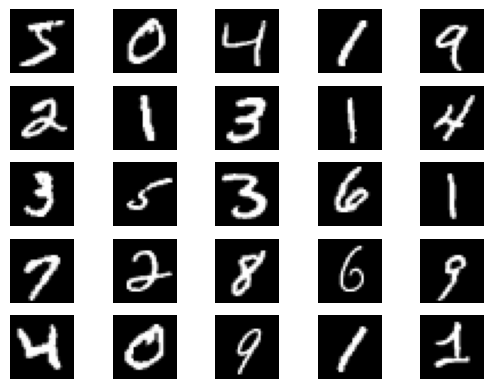

In [ ]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)
# plot images from the training dataset
for i in range(25):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap='gray')
pyplot.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

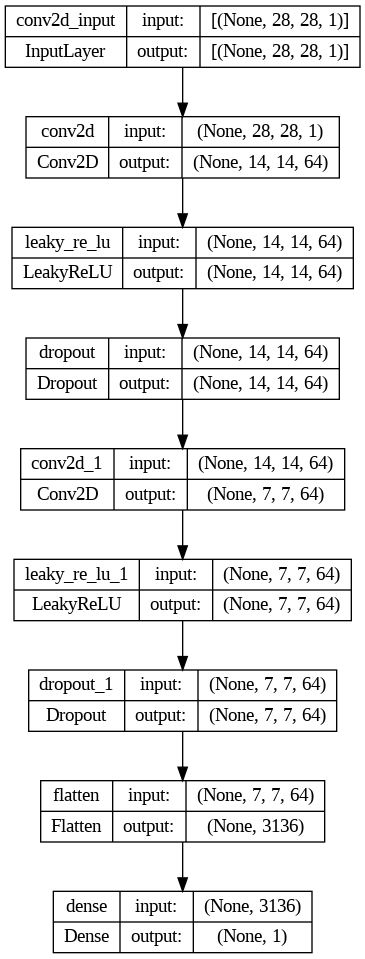

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential([
        Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Conv2D(64, (3,3), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

    # Compile model with Adam optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define and summarize the model
model = define_discriminator()
model.summary()

# Plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                           

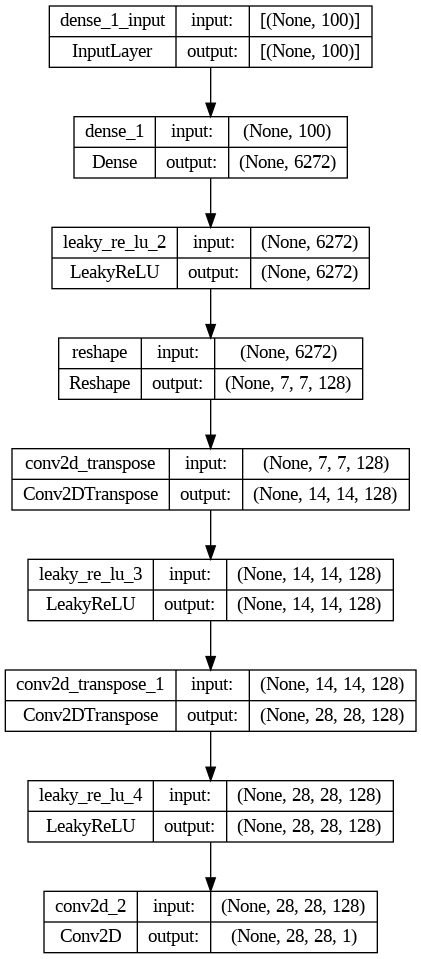

In [ ]:
# Import necessary libraries from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.utils import plot_model

# Define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # Foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# Define the size of the latent space
latent_dim = 100
# Define the generator model
model = define_generator(latent_dim)
# Summarize the model
model.summary()
# Plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  #opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


In [ ]:
# load and prepare mnist training images
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, 1))
  return X, y


In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y


In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)


In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Function to load real samples
def load_real_samples():
    # Load the MNIST dataset
    (trainX, _), (_, _) = mnist.load_data()
    # Expand to 3d, e.g., add channels dimension
    X = np.expand_dims(trainX, axis=-1)
    # Convert from unsigned ints to floats
    X = X.astype('float32')
    # Scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# Define the generator, discriminator, and GAN model as assumed in previous responses
def define_generator(latent_dim):
    model = Sequential([
        Dense(128 * 7 * 7, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 128)),
        Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2D(1, (7,7), activation='sigmoid', padding='same')
    ])
    return model

def define_discriminator():
    model = Sequential([
        Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Conv2D(64, (3,3), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  # Updated from 'lr' to 'learning_rate'
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_gan(g_model, d_model):
    d_model.trainable = False  # Make discriminator not trainable when combined into GAN
    model = Sequential([g_model, d_model])
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  # Update from `lr` to `learning_rate`
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Presumed setup and invocation
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()  # Properly defined now with required imports
# Train function call would go here (not shown for brevity)


In [ ]:
import numpy as np
from numpy import vstack, ones, zeros

# Generates real samples with class labels
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

# Generates fake samples with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    X = generator.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# Generates points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    return x_input.reshape(n_samples, latent_dim)

# Summarizes the performance of the generator and discriminator
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim):
    print(f"Summary of performance at end of epoch {epoch+1}")


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)


4/4 [==============================] - 0s 4ms/step
>1, 1/234, d=0.707, g=0.668
4/4 [==============================] - 0s 5ms/step
>1, 2/234, d=0.699, g=0.693
4/4 [==============================] - 0s 5ms/step
>1, 3/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.682, g=0.721
4/4 [==============================] - 0s 4ms/step
>1, 5/234, d=0.676, g=0.741
4/4 [==============================] - 0s 5ms/step
>1, 6/234, d=0.663, g=0.757
4/4 [==============================] - 0s 3ms/step
>1, 7/234, d=0.662, g=0.775
4/4 [==============================] - 0s 3ms/step
>1, 8/234, d=0.652, g=0.790
4/4 [==============================] - 0s 3ms/step
>1, 9/234, d=0.649, g=0.807
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d=0.639, g=0.817
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d=0.638, g=0.827
4/4 [==============================] - 0s 3ms/step
>1, 12/234, d=0.639, g=0.828
4/4 [==============================] - 0s 3ms/ste

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=25, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)


Streaming output truncated to the last 5000 lines.
>15, 75/234, d=0.693, g=0.711
4/4 [==============================] - 0s 3ms/step
>15, 76/234, d=0.690, g=0.705
4/4 [==============================] - 0s 3ms/step
>15, 77/234, d=0.697, g=0.719
4/4 [==============================] - 0s 4ms/step
>15, 78/234, d=0.683, g=0.702
4/4 [==============================] - 0s 3ms/step
>15, 79/234, d=0.692, g=0.694
4/4 [==============================] - 0s 4ms/step
>15, 80/234, d=0.692, g=0.695
4/4 [==============================] - 0s 3ms/step
>15, 81/234, d=0.690, g=0.692
4/4 [==============================] - 0s 3ms/step
>15, 82/234, d=0.682, g=0.698
4/4 [==============================] - 0s 3ms/step
>15, 83/234, d=0.691, g=0.708
4/4 [==============================] - 0s 3ms/step
>15, 84/234, d=0.676, g=0.704
4/4 [==============================] - 0s 4ms/step
>15, 85/234, d=0.684, g=0.724
4/4 [==============================] - 0s 3ms/step
>15, 86/234, d=0.679, g=0.727
4/4 [=======================

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 50
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)


4/4 [==============================] - 0s 5ms/step
>1, 1/234, d=0.688, g=0.744
4/4 [==============================] - 0s 4ms/step
>1, 2/234, d=0.679, g=0.758
4/4 [==============================] - 0s 4ms/step
>1, 3/234, d=0.672, g=0.779
4/4 [==============================] - 0s 3ms/step
>1, 4/234, d=0.663, g=0.797
4/4 [==============================] - 0s 3ms/step
>1, 5/234, d=0.661, g=0.818
4/4 [==============================] - 0s 3ms/step
>1, 6/234, d=0.654, g=0.837
4/4 [==============================] - 0s 3ms/step
>1, 7/234, d=0.644, g=0.852
4/4 [==============================] - 0s 3ms/step
>1, 8/234, d=0.642, g=0.863
4/4 [==============================] - 0s 3ms/step
>1, 9/234, d=0.635, g=0.877
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d=0.635, g=0.874
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d=0.633, g=0.868
4/4 [==============================] - 0s 4ms/step
>1, 12/234, d=0.636, g=0.854
4/4 [==============================] - 0s 3ms/ste